# Basic test for correlation

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm import tqdm

from dataset.midi import process_midi_separating_instruments_mido
from dataset.utils import load_pickle_data

from ripdalib.utils.morphology import erosion, dilation
from ripdalib.variations.transform import list_to_matrix, matrix_to_list, middlepoints_to_onsets
from ripdalib.variations.plot import plot_matrix, plot_correlation, plot_patterns_from_correlation
from ML.utils import correlation, my_dilatation

In [5]:
data = process_midi_separating_instruments_mido("./bach_850.mid", 16)
length_subject = 12 #19 for 847, 13 for 846
quantization = 16 #8
fugua_names_list = ('Track 3', 'Track 4', 'Track 5', 'Track 6')
nbr_fugua_subject = 3 # 1 for 846 and 847
data.keys()

dict_keys(['midi_file', 'Track 1', 'Track 2', 'Track 3', 'Track 4', 'Track 5', 'Track 6'])

In [ ]:
def basic_plot(tracks):
    plt.figure(figsize=(20, 10))
    for track in tracks.values():
        onsets = [elem[0] for elem in track]
        pitches = [elem[1] for elem in track]

        plt.scatter(onsets, pitches)

    plt.show()


def merge_instruments(tracks):
    merged = list()
    for name, track in tracks.items():
        if not name == "midi_file":
            merged.extend(track)
    merged = sorted(merged, key=lambda x: x[0])
    return merged



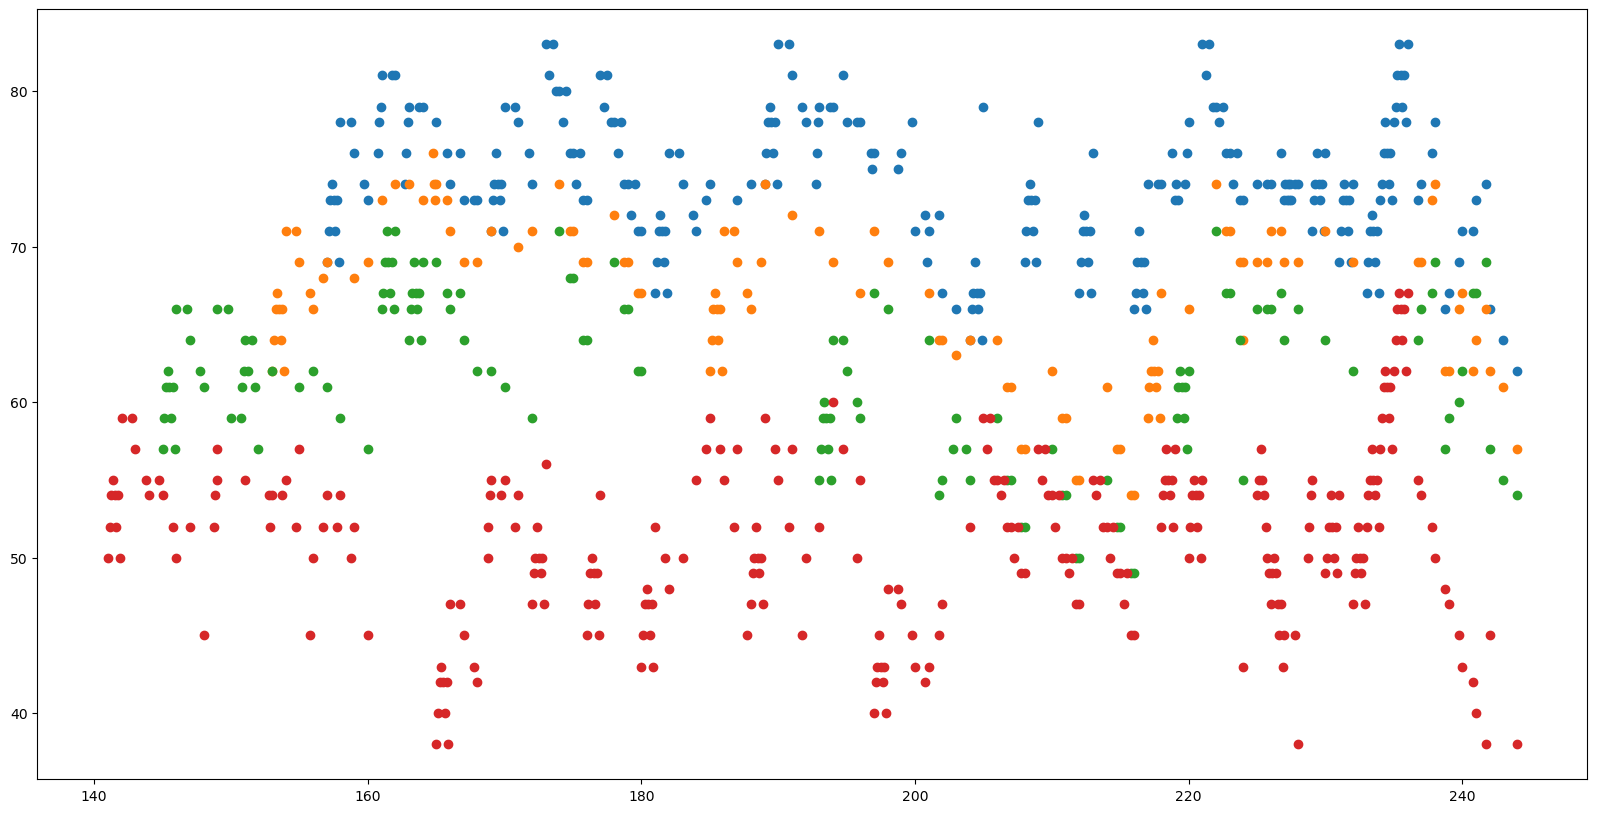

In [7]:
tracks = {key: data[key] for key in fugua_names_list}
basic_plot(tracks)

In [8]:
subject = data[fugua_names_list[nbr_fugua_subject]][:length_subject]

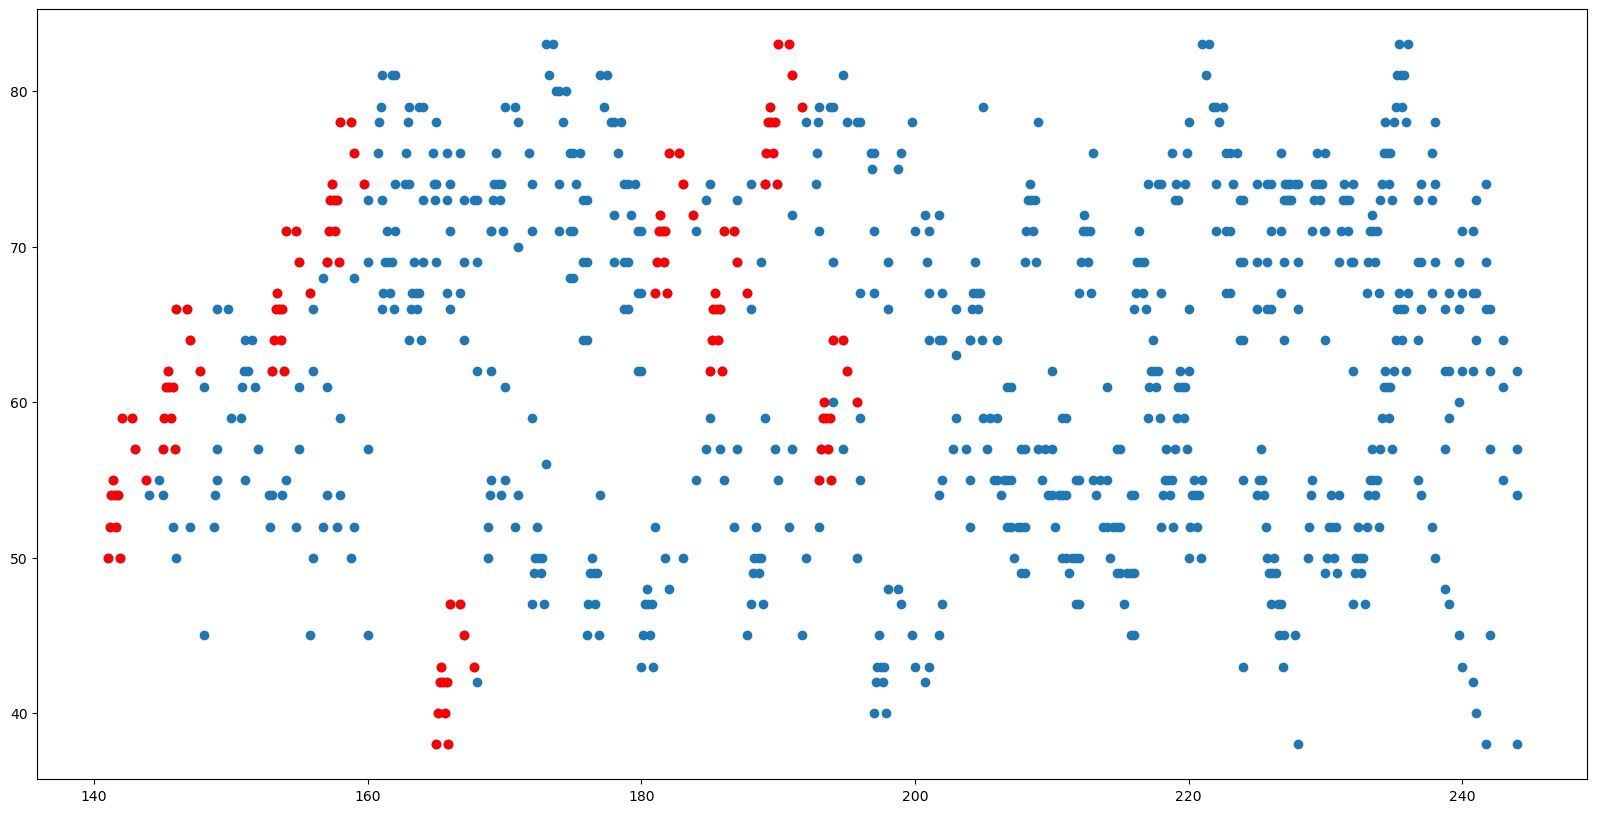

In [ ]:
fugua = merge_instruments(tracks)

subject_onsets = erosion(fugua, subject)
subject_all = dilation(subject_onsets, subject)

plt.figure(figsize=(20, 10))
plt.scatter(*zip(*fugua))
plt.scatter(*zip(*subject_all), color='red')
plt.show()

## Correlation map

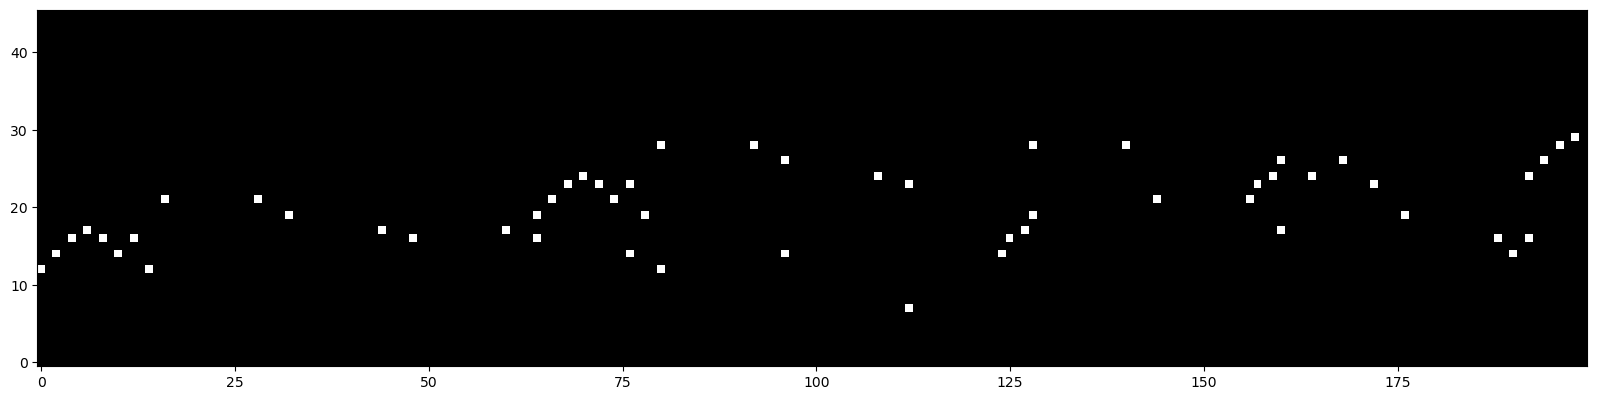

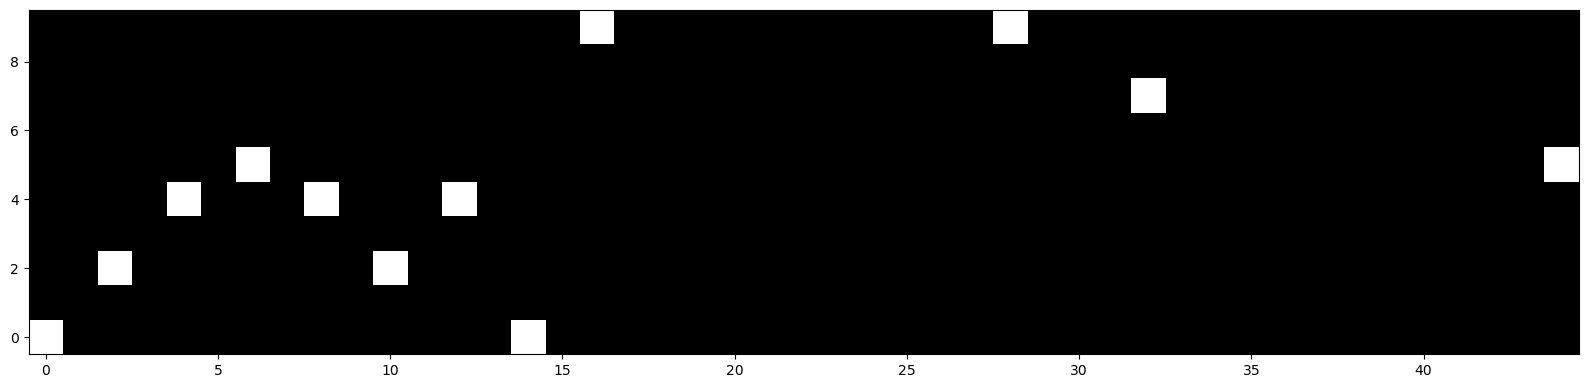

In [10]:
fugua_image = list_to_matrix(fugua, quantization)
subject_image = list_to_matrix(subject, quantization)

plot_matrix(fugua_image[:200])
plot_matrix(subject_image)

In [11]:
map = correlation(fugua_image, subject_image).squeeze((0, 1))

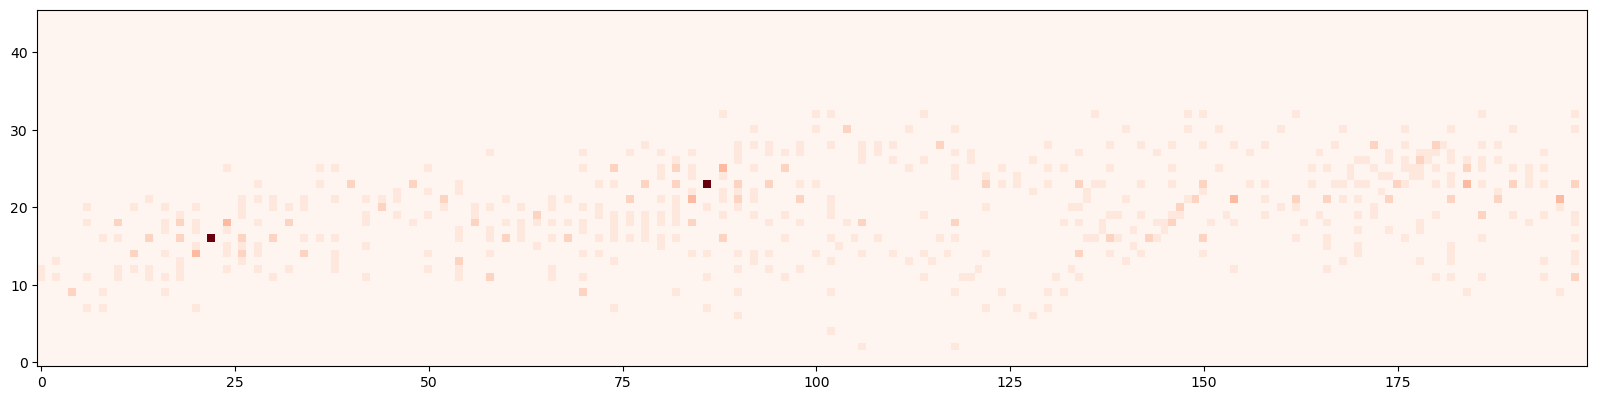

In [12]:
plot_correlation(map[:200])

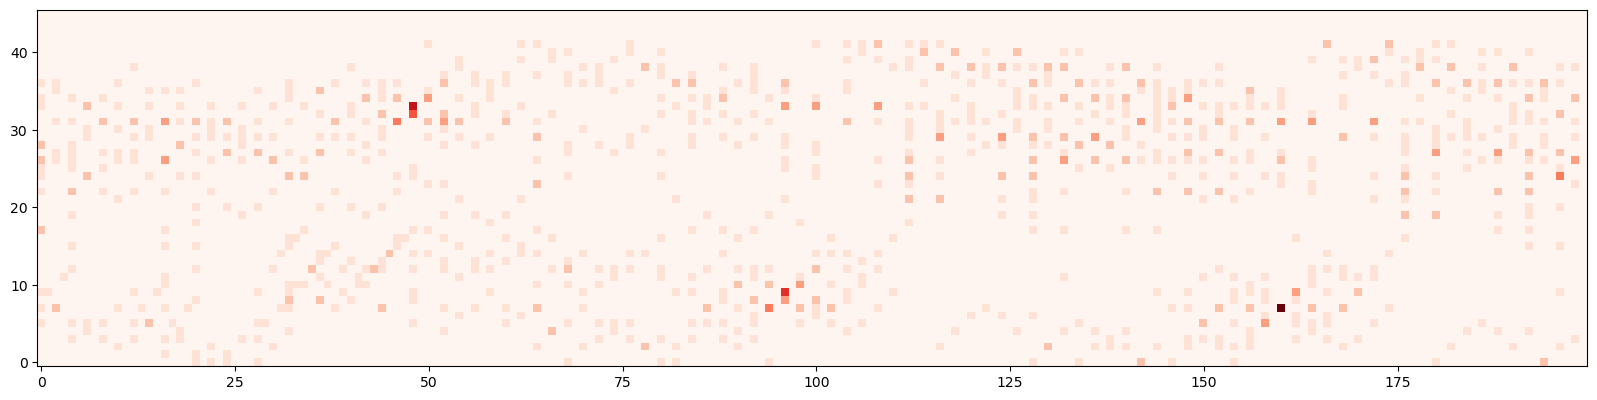

In [13]:
shifted_map = middlepoints_to_onsets(map, subject_image)
plot_correlation(shifted_map[400:600])

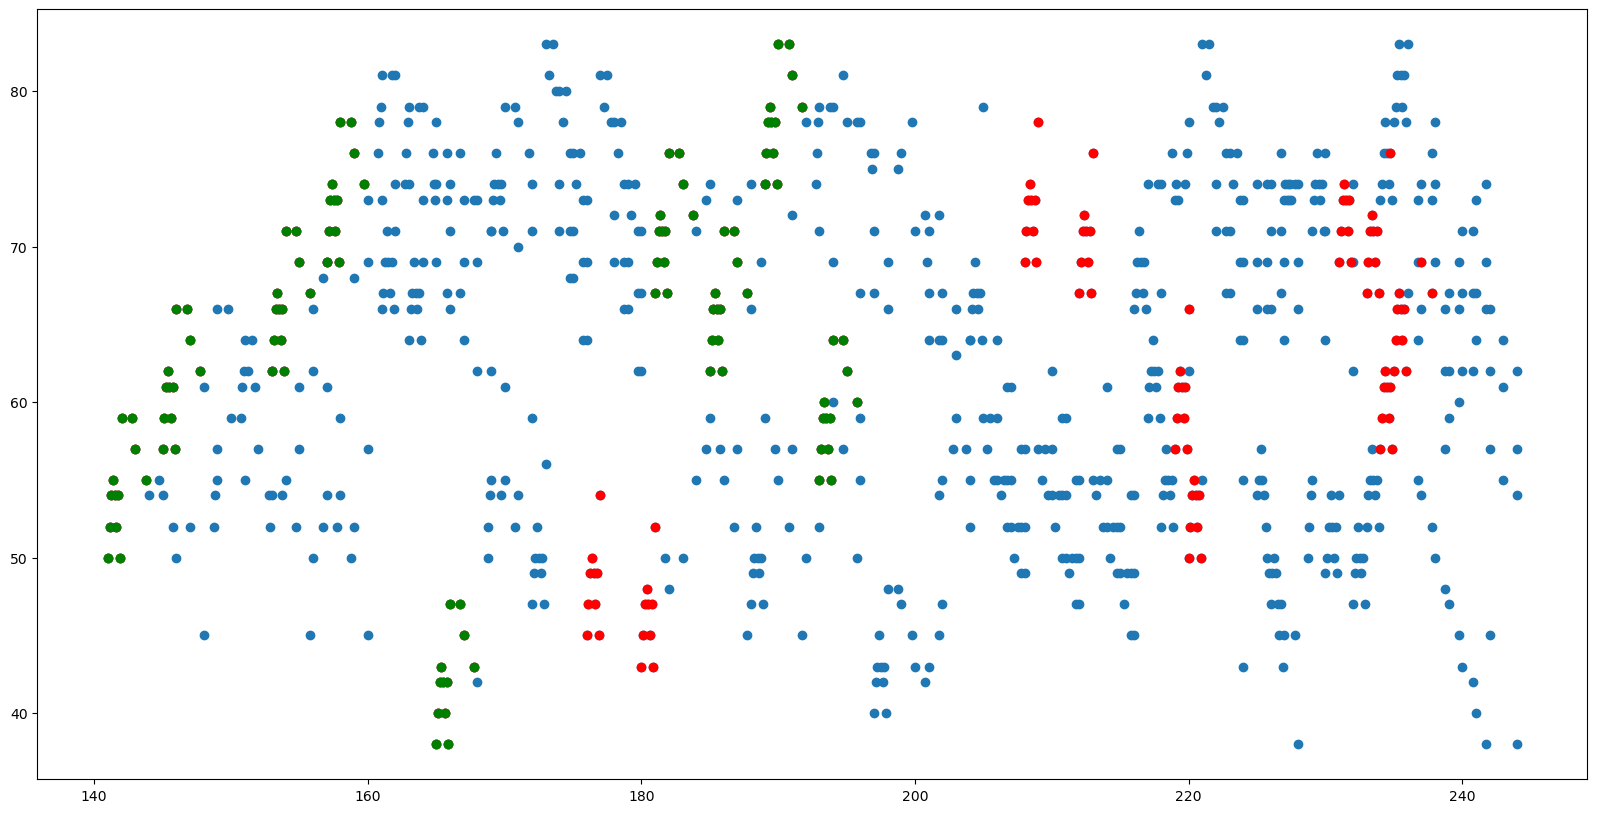

In [14]:
new_patterns = my_dilatation(map>=0.6, subject_image).squeeze((0, 1)) * fugua_image

new_patterns_list = matrix_to_list(new_patterns, mindiv=quantization)

translations = fugua[np.argmin([fugua[i][0] for i in range(len(fugua))])]
translations = [translations[0], translations[1] - new_patterns_list[0][1]]

new_patterns_list = [(note[0] +translations[0], note[1] + translations[1]) for note in new_patterns_list]



plt.figure(figsize=(20, 10))
plt.scatter(*zip(*fugua))
plt.scatter(*zip(*new_patterns_list), color='red')
plt.scatter(*zip(*subject_all), color='green')
plt.show()

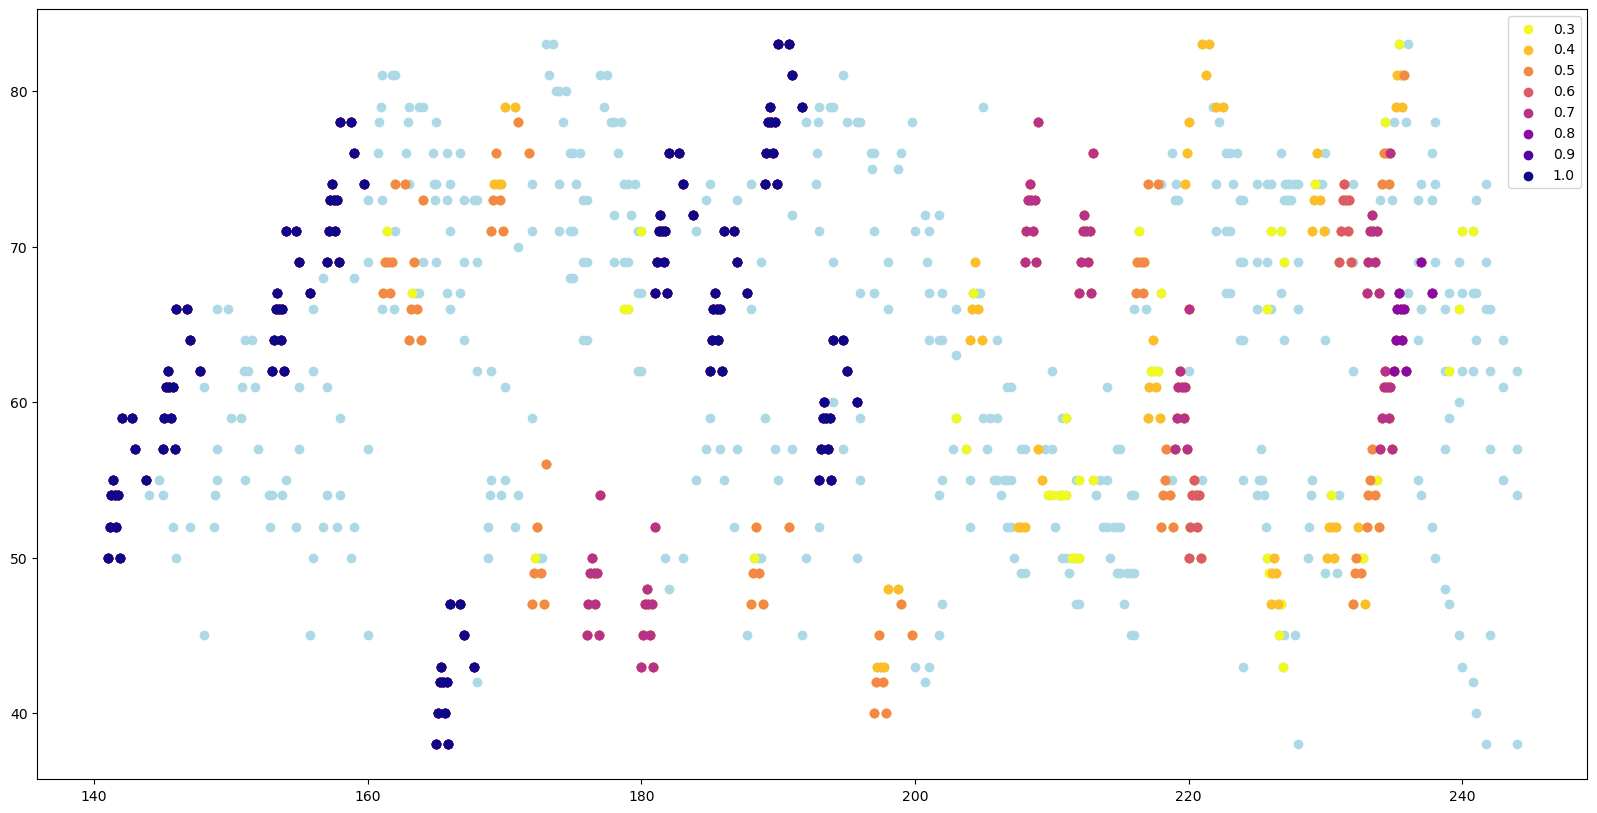

In [15]:
plt.figure(figsize=(20, 10))
plt.scatter(*zip(*fugua), color="lightblue")

color_map = plt.get_cmap("plasma")
color_map = [color_map(i) for i in np.linspace(1, 0, 11-3)]

for prop in range(3,11,1):
    new_patterns = my_dilatation(map>=prop/10, subject_image).squeeze((0, 1)) * fugua_image
    new_patterns_list = matrix_to_list(new_patterns, mindiv=quantization)

    translations = fugua[np.argmin([fugua[i][0] for i in range(len(fugua))])]
    translations = [translations[0], translations[1] - new_patterns_list[0][1]]

    new_patterns_list = [(note[0] +translations[0], note[1] + translations[1]) for note in new_patterns_list]

    plt.scatter(*zip(*new_patterns_list), color=color_map[prop-3], label=str(prop/10))

plt.legend()
plt.show()

## FOR 861

In [16]:
data = process_midi_separating_instruments_mido("./bach_861.mid", 16)
length_subject = 10
quantization = 16
data.keys()

dict_keys(['midi_file', 'Track 1'])

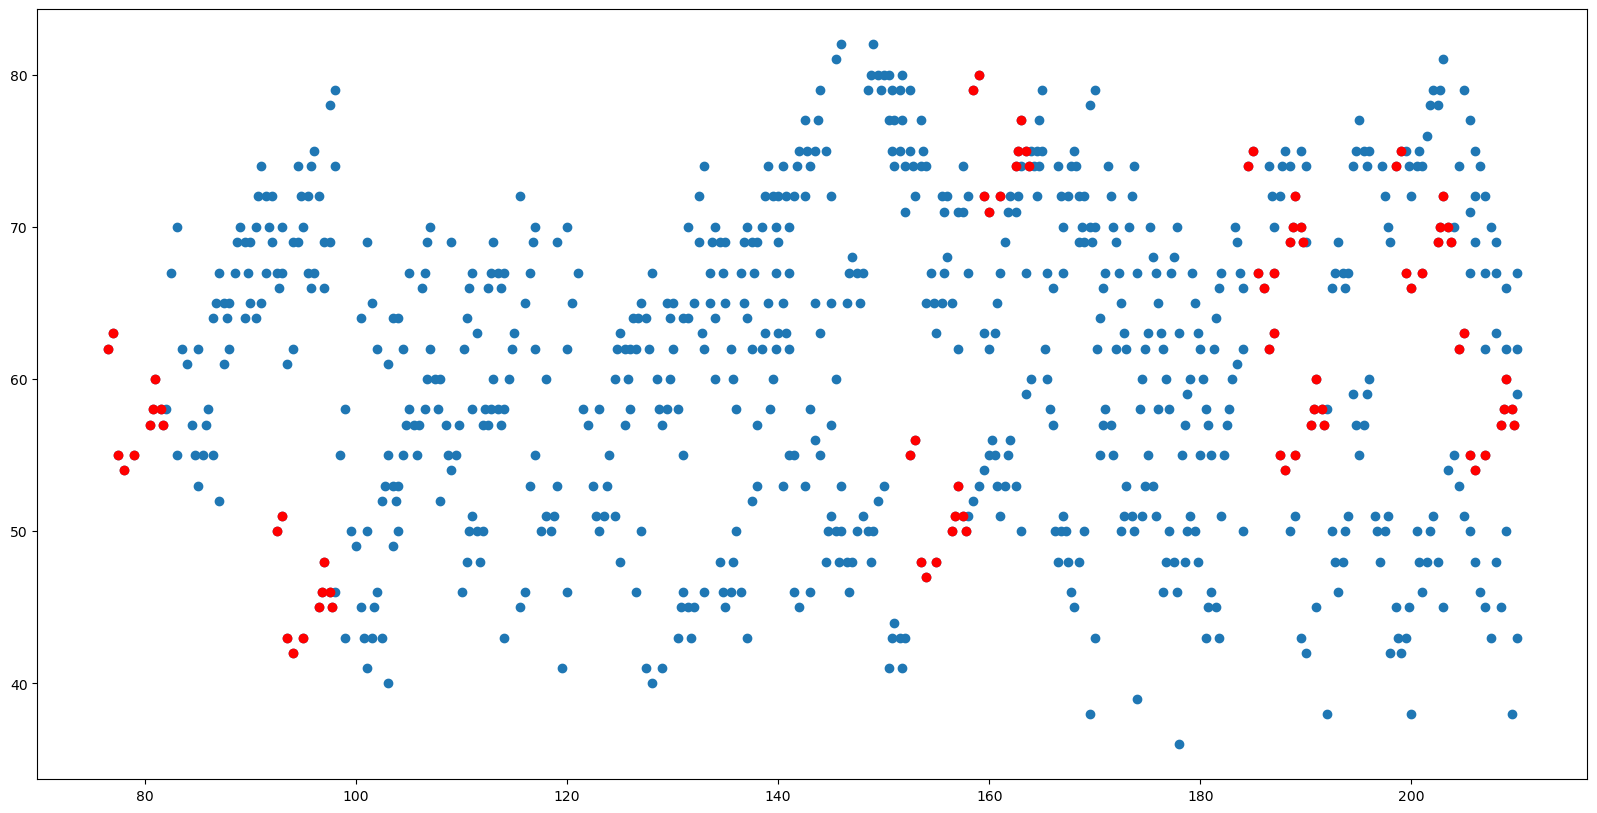

In [ ]:
fugua = data["Track 1"]
fugua = [note for note in fugua if note[0] > 19 * 4] #remove the prelude (19 bars in 4/4)
subject = fugua[:length_subject]

subject_onsets = erosion(fugua, subject)
subject_all = dilation(subject_onsets, subject)

plt.figure(figsize=(20, 10))
plt.scatter(*zip(*fugua))
plt.scatter(*zip(*subject_all), color='red')
plt.show()

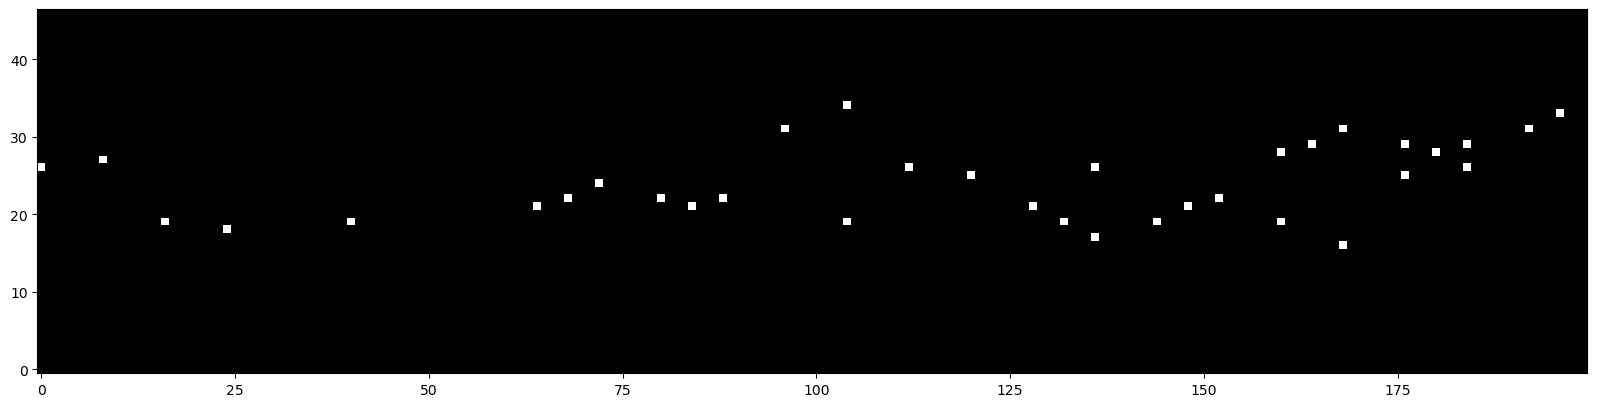

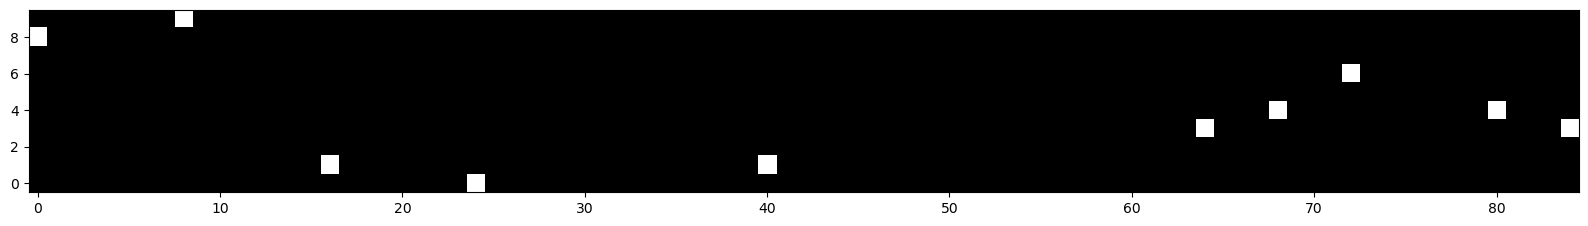

In [18]:
fugua_image = list_to_matrix(fugua, quantization)
subject_image = list_to_matrix(subject, quantization)

plot_matrix(fugua_image[:200])
plot_matrix(subject_image)

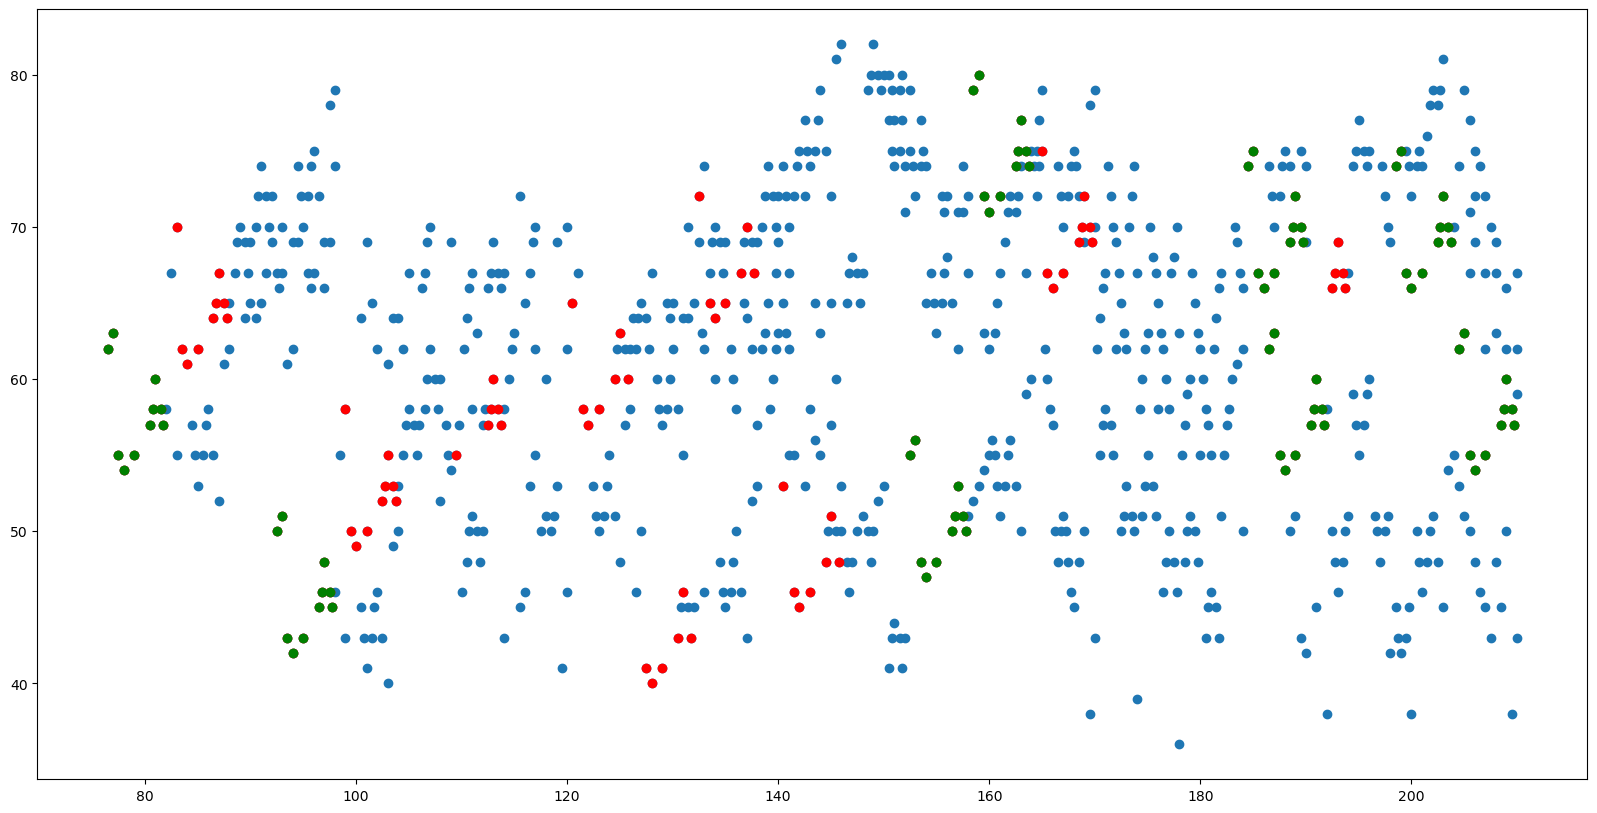

In [19]:
map = correlation(fugua_image, subject_image).squeeze((0, 1))

new_patterns = my_dilatation(map>=0.6, subject_image).squeeze((0, 1)) * fugua_image

new_patterns_list = matrix_to_list(new_patterns, mindiv=quantization)

translations = fugua[np.argmin([fugua[i][0] for i in range(len(fugua))])]
translations = [translations[0], translations[1] - new_patterns_list[0][1]]

new_patterns_list = [(note[0] +translations[0], note[1] + translations[1]) for note in new_patterns_list]



plt.figure(figsize=(20, 10))
plt.scatter(*zip(*fugua))
plt.scatter(*zip(*new_patterns_list), color='red')
plt.scatter(*zip(*subject_all), color='green')
plt.show()

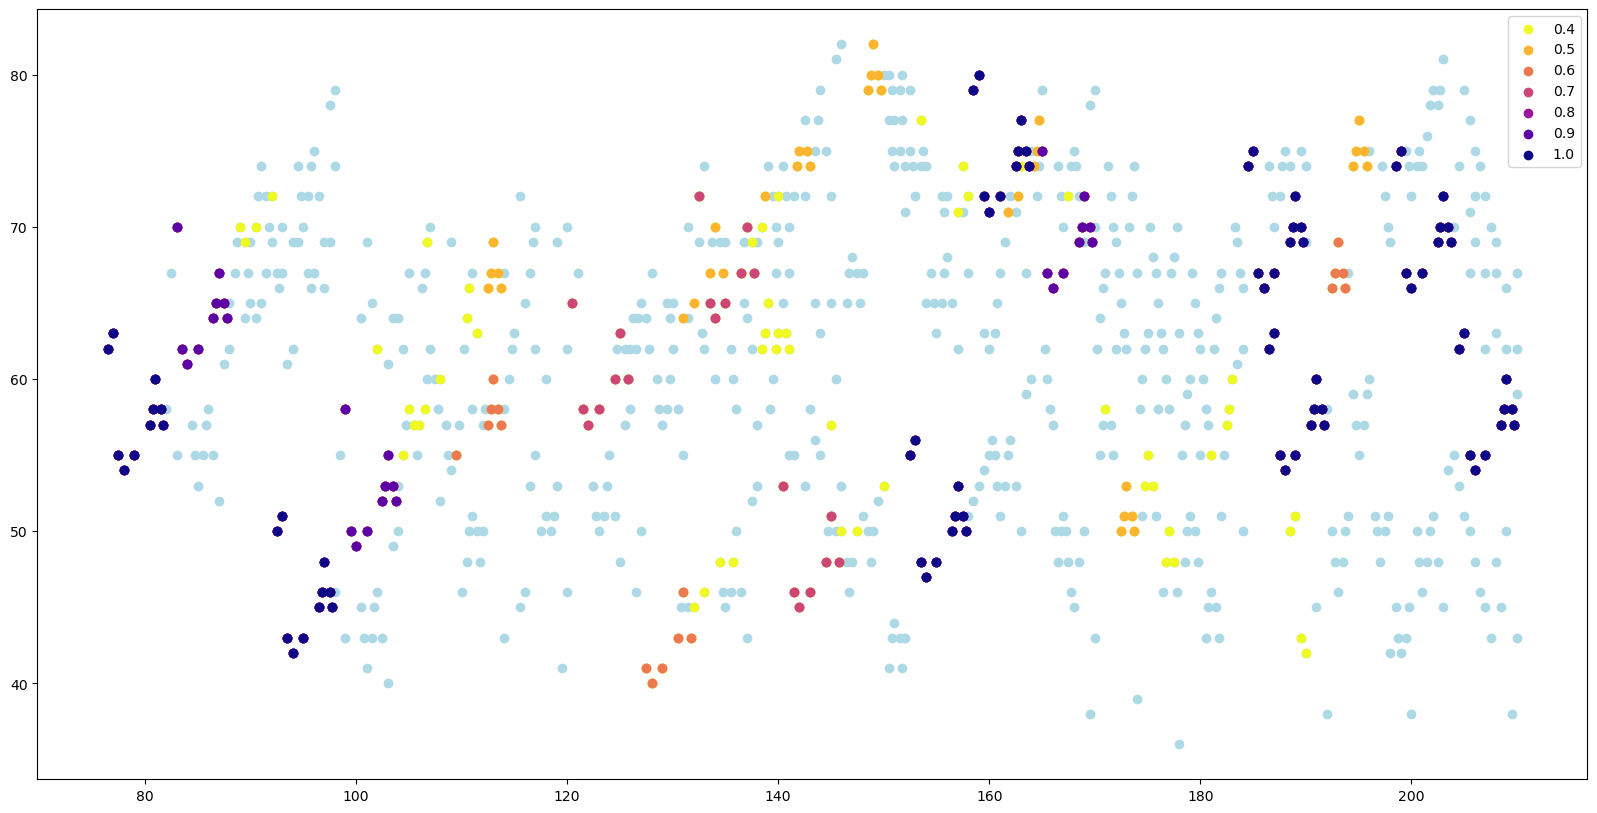

In [20]:
plt.figure(figsize=(20, 10))
plt.scatter(*zip(*fugua), color="lightblue")

color_map = plt.get_cmap("plasma")
color_map = [color_map(i) for i in np.linspace(1, 0, 11-4)]

for prop in range(4,11):
    new_patterns = my_dilatation(map>=prop/10, subject_image).squeeze((0, 1)) * fugua_image
    new_patterns_list = matrix_to_list(new_patterns, mindiv=quantization)

    translations = fugua[np.argmin([fugua[i][0] for i in range(len(fugua))])]
    translations = [translations[0], translations[1] - new_patterns_list[0][1]]

    new_patterns_list = [(note[0] +translations[0], note[1] + translations[1]) for note in new_patterns_list]

    plt.scatter(*zip(*new_patterns_list), color=color_map[prop-4], label=str(prop/10))

plt.legend()
plt.show()

## From the fugues dataset

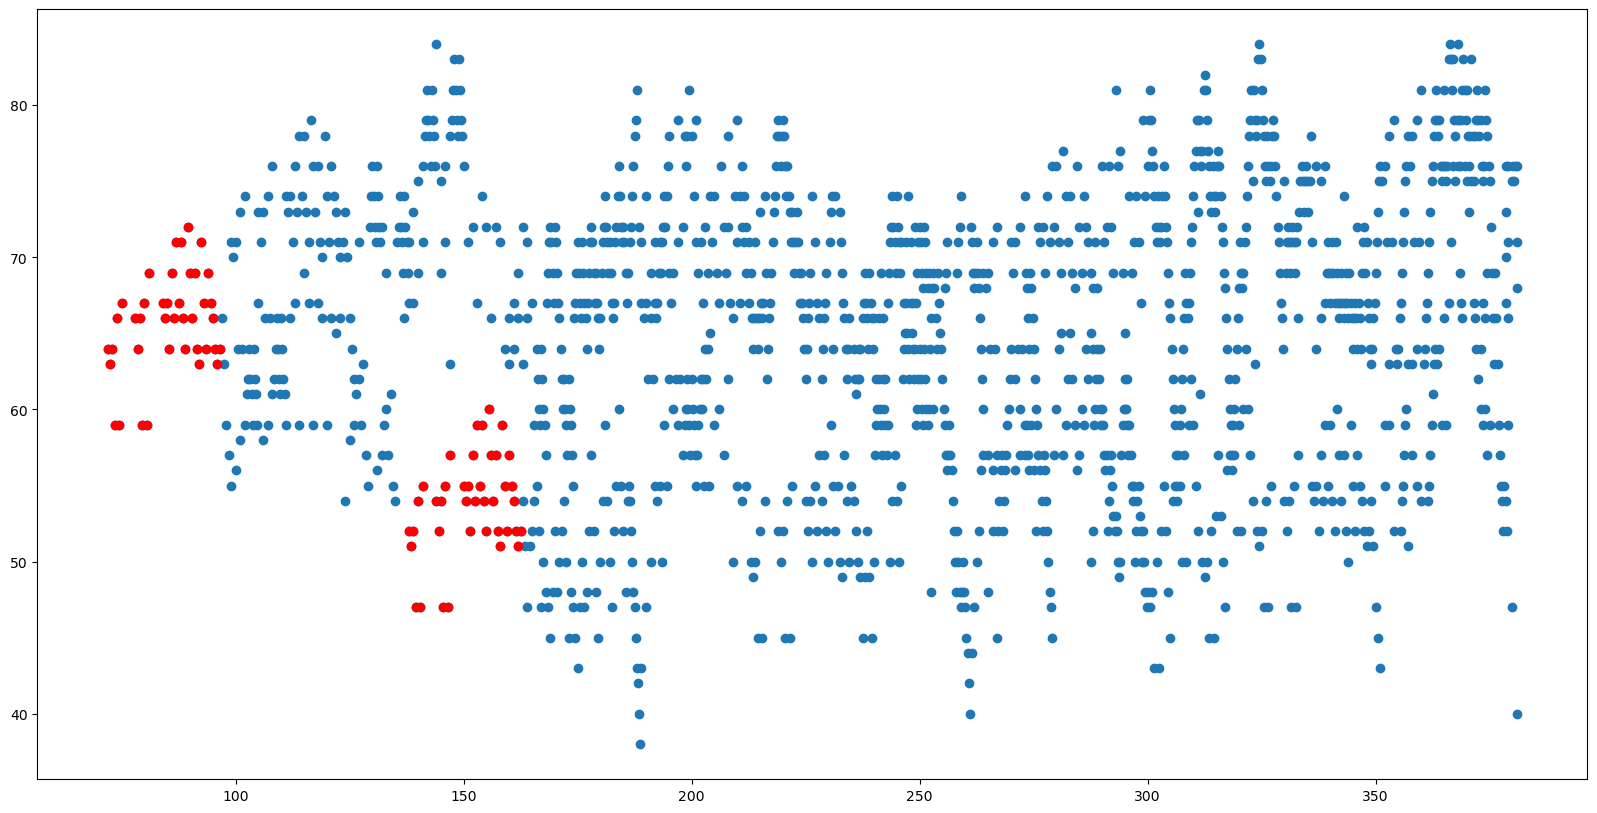

In [2]:
IMAGE = load_pickle_data(os.path.join("Fugues_data", "data.pkl"))["BWV_0900"]
fugua = sorted(IMAGE, key=lambda x: x[0])

length_subject = 40
quantization = 16


subject = fugua[:length_subject]
subject_onsets = erosion(fugua, subject)
subject_all = dilation(subject_onsets, subject)

plt.figure(figsize=(20, 10))
plt.scatter(*zip(*fugua))
plt.scatter(*zip(*subject_all), color='red')
plt.show()

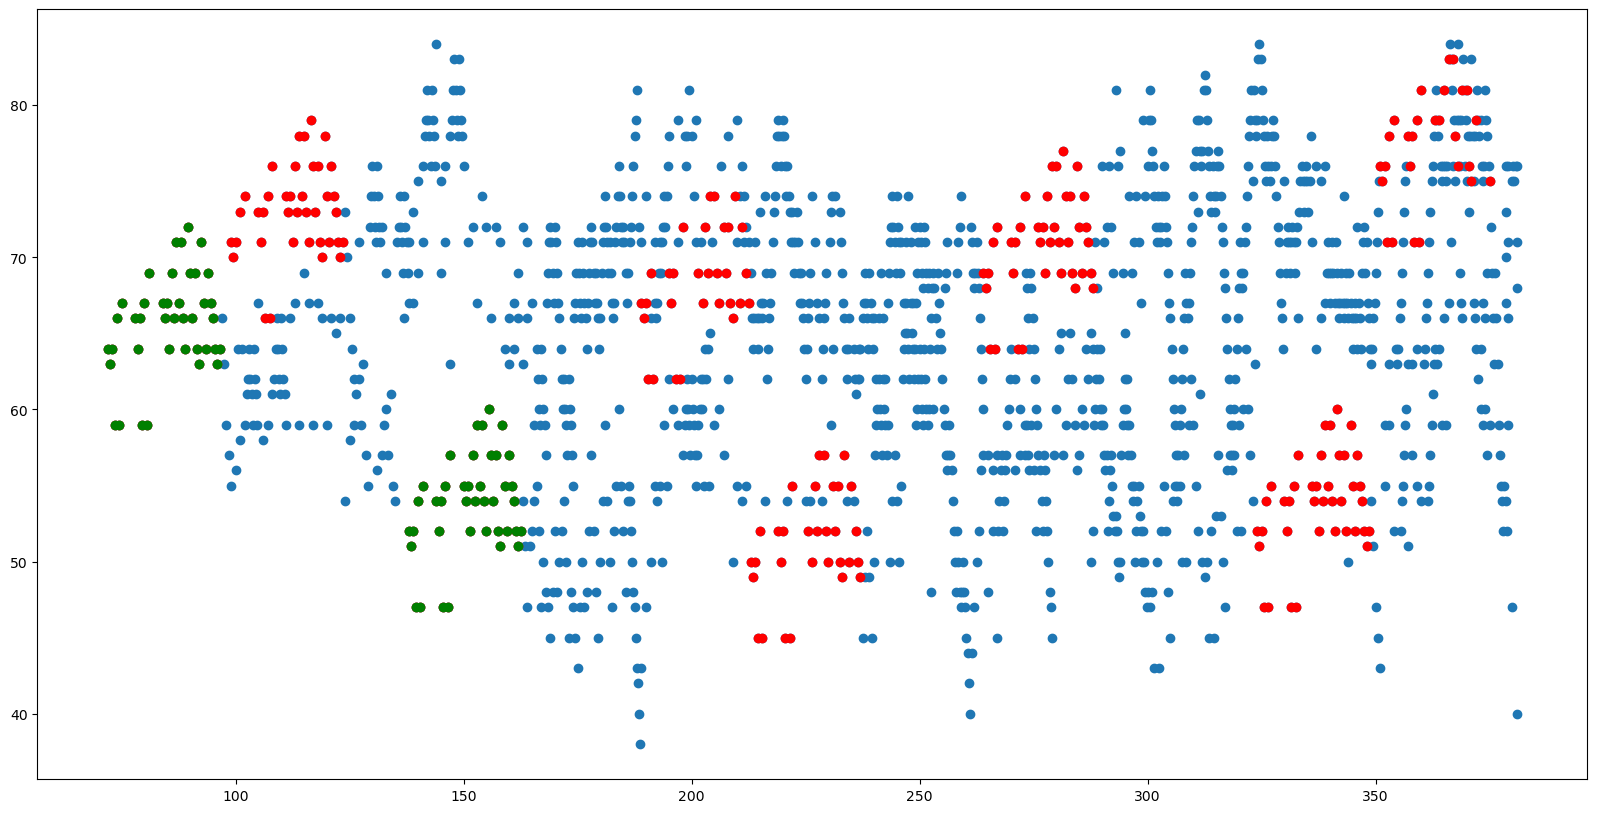

In [3]:
fugua_image = list_to_matrix(fugua, quantization)
subject_image = list_to_matrix(subject, quantization)

map = correlation(fugua_image, subject_image).squeeze((0, 1))

plot_patterns_from_correlation(map, fugua, subject, threshold=0.4, quantization=quantization)

Correlation local avec souspartie non utilisé du pattern